In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn_extra.cluster import KMedoids
import folium
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.colors as mcolors
from haversine import haversine
import branca.colormap as cm
from IPython.display import IFrame

In [2]:
# Load your data into a DataFrame:
data = pd.read_excel("1922_toba.xlsx")

In [3]:
columns_to_remove = ['date', 'OT (UTC)', 'Region', 'Jarak', 'Dirasakan', 'tipe']
data_numeric = data.drop(columns=columns_to_remove)

In [4]:
# Display the first few rows of the dataset to get a sense of the data
print(data_numeric.head())

   latitude  longitude  magnitude  depth
0      2.62      98.46        2.3      5
1      1.91      98.99        3.5    120
2      2.56      98.63        2.4      1
3      2.56      98.62        2.1      3
4      3.15      98.02        3.4      1


In [5]:
# Summary statistics
summary_stats = data_numeric.describe()
print(summary_stats)
# Export the summary statistics to an Excel file
summary_stats.to_excel("summary_statistics.xlsx")

          latitude    longitude    magnitude        depth
count  1069.000000  1069.000000  1069.000000  1069.000000
mean      2.247603    98.896590     2.737775    38.734331
std       0.508584     0.310090     0.645342    54.151236
min       1.300000    98.000000     0.900000     1.000000
25%       1.800000    98.770000     2.300000     3.000000
50%       2.365931    98.900620     2.700000    10.000000
75%       2.580000    99.069237     3.100000    79.000000
max       3.620000   100.110000     5.400000   209.000000


Text(0, 0.5, 'Frequency')

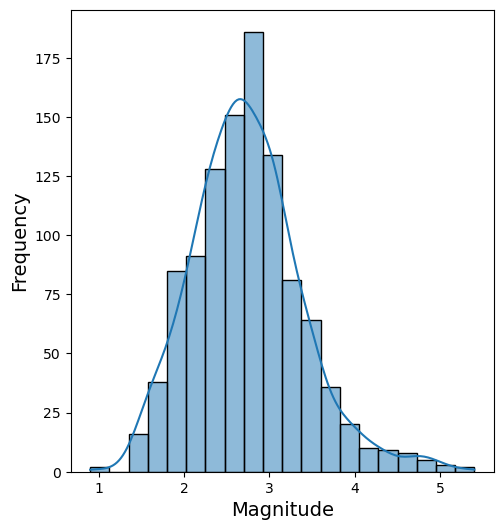

In [6]:
# Data distribution and histograms
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data_numeric['magnitude'], kde=True, bins=20)
plt.xlabel('Magnitude', fontsize=14)  # Adjust the x label fontsize as needed
plt.ylabel('Frequency', fontsize=14)  # Adjust the y label fontsize as needed


Text(0, 0.5, 'Frequency')

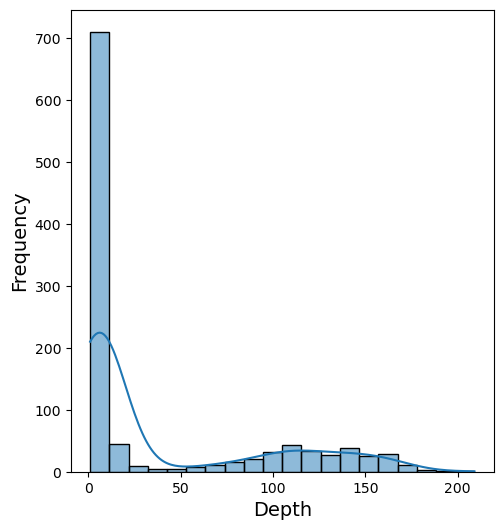

In [83]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data_numeric['depth'], kde=True, bins=20)
plt.xlabel('Depth', fontsize=14)  # Adjust the x label fontsize as needed
plt.ylabel('Frequency', fontsize=14)  # Adjust the y label fontsize as needed

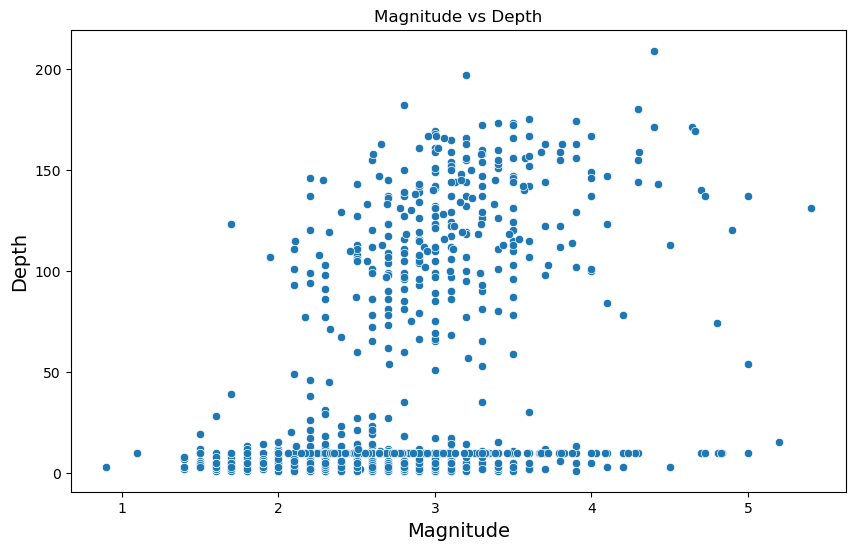

In [8]:
# Scatter plot to visualize relationships
plt.figure(figsize=(10, 6))
sns.scatterplot(x='magnitude', y='depth', data=data_numeric)
plt.xlabel('Magnitude', fontsize=14)  # Adjust the fontsize as needed
plt.ylabel('Depth', fontsize=14)  # Adjust the fontsize as needed
plt.title('Magnitude vs Depth')
plt.show()

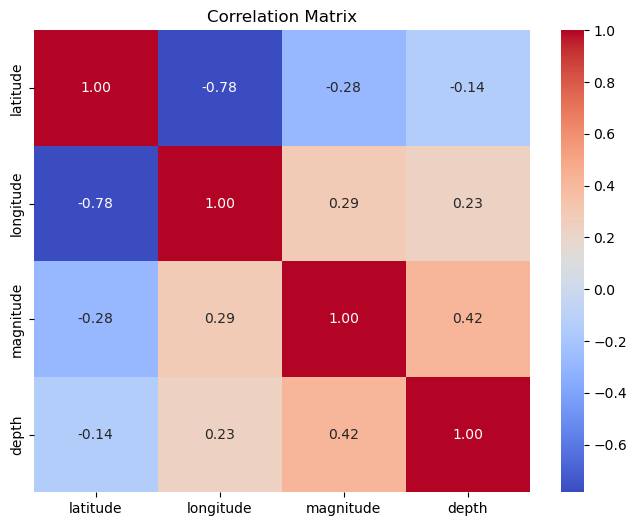

In [9]:
# Correlation matrix
correlation_matrix = data_numeric.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [75]:
# Create a map centered on a specific location (you can adjust the location and zoom level)
m = folium.Map(location=[-2.5489, 118.0149], zoom_start=5)
folium.TileLayer('https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 
                 attr='OpenStreetMap').add_to(m)


In [76]:
# Define your custom StepColormap for earthquake magnitude
colormap_magnitude = cm.StepColormap(
    colors=['#ff0000', '#ff3300', '#ff6600', '#ff9900', '#ffcc00', '#ffff00'],
    vmin=data['magnitude'].min(),
    vmax=data['magnitude'].max(),
    index=[0, 3, 4, 5, 7, 10, 25])

# Add markers for earthquake points with variable radius based on magnitude and a legend
for index, row in data.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    magnitude = row['magnitude']

    # Determine the marker color based on magnitude using the custom colormap
    color = colormap_magnitude(magnitude)

    # Adjust the radius based on the magnitude
    radius = 1 + (magnitude - data['magnitude'].min()) / (data['magnitude'].max() - data['magnitude'].min()) * 2

    # Create a marker for each earthquake point
    folium.CircleMarker(
        location=[lat, lon],
        radius=radius,  # Variable radius based on magnitude
        color=color,  # Marker color based on magnitude
        fill=True,
        fill_color=color,
        fill_opacity=0.6,  # Adjust the opacity as needed
        popup=f"Magnitude: {magnitude}",  # Display earthquake information on click
    ).add_to(m)

# Add the magnitude legend based on the custom colormap
colormap_magnitude.caption = "Magnitude"
colormap_magnitude.add_to(m)


In [77]:
# Save the map to an HTML file
m.save("earthquake_scatter_map_custom_colormap_legend_red.html")

In [78]:
# Specify the path to your HTML file
html_file_path = 'earthquake_scatter_map_custom_colormap_legend_red.html'

# Use IFrame to embed the HTML file in the notebook
IFrame(src=html_file_path, width='100%', height=500)


In [15]:
# Select the columns to use, including 'Kedalaman'
selected_columns = ['latitude', 'longitude', 'magnitude', 'depth']
data_selected = data[selected_columns]
data_selected = pd.DataFrame(data_selected)

In [16]:
# Handle NaN values
data_selected.fillna(data_selected.mean(), inplace=True)

# Use Min-Max scaling to normalize the data
scaler = MinMaxScaler()  # Create a MinMaxScaler instance
data_scaled = scaler.fit_transform(data_selected)

In [17]:
# Define the number of clusters (K)
max_iter = 300
k = 10

In [18]:
# Create a K-Medoids model with PAM initialization using Haversine distance and Magnitude, Depth difference
kmedoids = KMedoids(n_clusters=k, metric="precomputed", method="pam", max_iter=max_iter, random_state=0)

In [20]:
# Calculate the distance matrix using Haversine distance and Magnitude, Depth difference
distance_matrix = np.zeros((len(data_scaled), len(data_scaled)))
for i in range(len(data_scaled)):
    for j in range(i, len(data_scaled)):  # Note that we can start from i since Haversine distance is symmetric
        coord1 = (data_selected.iloc[i]['latitude'], data_selected.iloc[i]['longitude'])
        coord2 = (data_selected.iloc[j]['latitude'], data_selected.iloc[j]['longitude'])
        distance = haversine(coord1, coord2, unit='km')
        magnitude_diff = abs(data_selected.iloc[i]['magnitude'] - data_selected.iloc[j]['magnitude'])
        depth_diff = abs(data_selected.iloc[i]['depth'] - data_selected.iloc[j]['depth'])

        # Combine Haversine distance, magnitude difference, and depth difference
        combined_distance = distance + magnitude_diff + depth_diff
        distance_matrix[i, j] = combined_distance
        distance_matrix[j, i] = combined_distance

In [21]:
# Fit the model using the precomputed distance matrix
kmedoids.fit(distance_matrix)

# Get cluster labels and medoids
cluster_labels = kmedoids.labels_
medoids = kmedoids.cluster_centers_

In [22]:
silhouette_scores = []

for k in range(2, 11):
    # Silhouette Score
    kmedoids = KMedoids(n_clusters=k, metric="euclidean", method="pam", random_state=0)
    kmedoids.fit(data_scaled)
    cluster_labels = kmedoids.labels_
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)


In [23]:
davies_bouldin_scores = []

for k in range(2, 11):
    # Davies-Bouldin Index
    kmedoids = KMedoids(n_clusters=k, metric="precomputed", method="pam", random_state=0)
    kmedoids.fit(distance_matrix)  # Assuming distance_matrix is your precomputed distance matrix
    cluster_labels = kmedoids.labels_
    davies_bouldin = davies_bouldin_score(data_scaled, cluster_labels)
    davies_bouldin_scores.append(davies_bouldin)

In [24]:
ch_scores = []

for k in range(2, 11):
    # CH Index
    kmedoids = KMedoids(n_clusters=k, metric="euclidean", method="pam", random_state=0)
    kmedoids.fit(data_scaled)
    cluster_labels = kmedoids.labels_
    ch_score = calinski_harabasz_score(data_scaled, cluster_labels)
    ch_scores.append(ch_score)

In [25]:
print(f"K={k}: Silhouette Score: {silhouette_avg:.2f}, Davies-Bouldin Index: {davies_bouldin:.2f}, CH Index: {ch_score:.2f}")

K=10: Silhouette Score: 0.37, Davies-Bouldin Index: 1.40, CH Index: 774.10


In [26]:
# Create a DataFrame to store Silhouette scores, Davies-Bouldin Indices, and CH Indices
result_df = pd.DataFrame({'K': list(range(2, 11)), 'Silhouette Score': silhouette_scores, 
                          'Davies-Bouldin Index': davies_bouldin_scores, 'CH Index': ch_scores})
print (result_df)

    K  Silhouette Score  Davies-Bouldin Index     CH Index
0   2          0.466925              0.937025   777.741418
1   3          0.460921              0.772698  1009.416114
2   4          0.428544              0.915487   879.033205
3   5          0.378397              1.083003   730.739833
4   6          0.336700              1.105332   692.069565
5   7          0.316265              1.027911   645.355208
6   8          0.344916              1.032810   745.953145
7   9          0.353750              0.980212   732.139050
8  10          0.370703              1.398228   774.100563


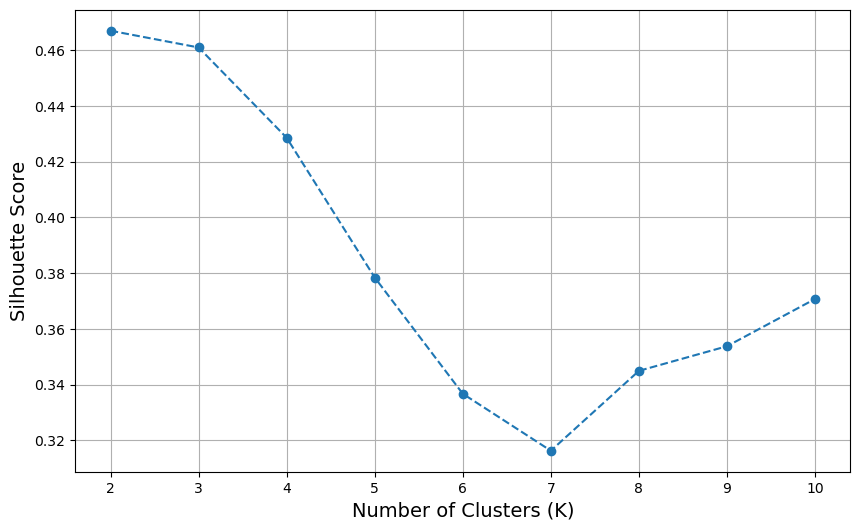

In [27]:
# Plot the Silhouette Score for different values of K
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.grid(True)
plt.show()

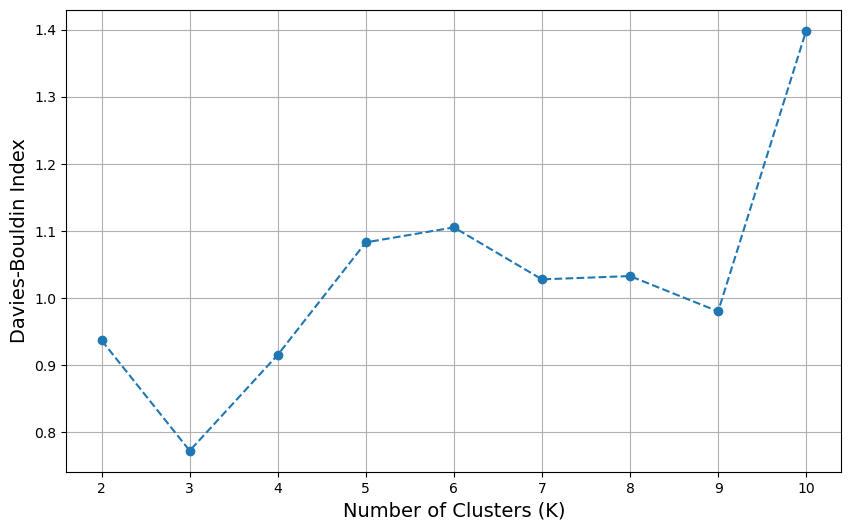

In [28]:
# Plot the Davies-Bouldin Index for different values of K
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), davies_bouldin_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)', fontsize=14)
plt.ylabel('Davies-Bouldin Index', fontsize=14)
plt.grid(True)
plt.show()


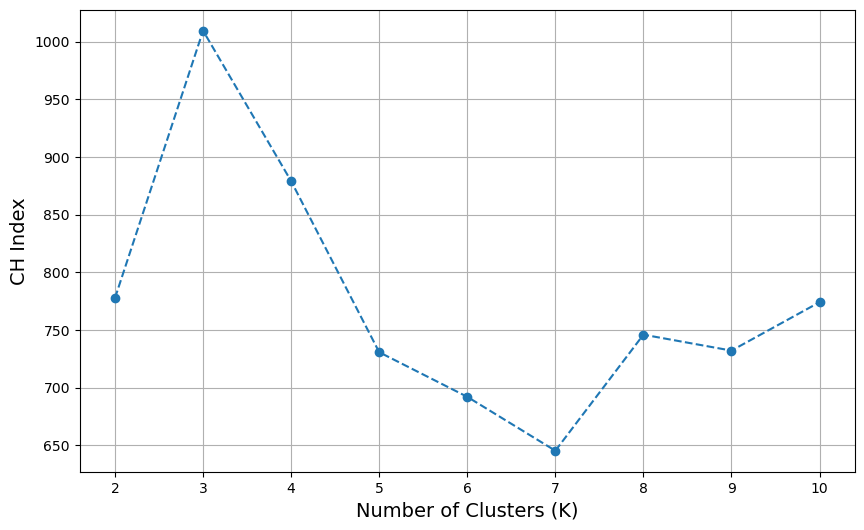

In [29]:
# Plot the CH Index for different values of K
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), ch_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)', fontsize=14)
plt.ylabel('CH Index', fontsize=14)
plt.grid(True)
plt.show()

In [30]:
# Find the optimal number of clusters based on the maximum silhouette score
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # Adding 2 because you started from K=2

optimal_kmedoids = KMedoids(n_clusters=optimal_k, metric="precomputed", method="pam", random_state=0)
optimal_kmedoids.fit(distance_matrix)
optimal_cluster_labels = optimal_kmedoids.labels_
optimal_medoids = optimal_kmedoids.cluster_centers_

print('0ptimal Silhouette score K=', optimal_k)


0ptimal Silhouette score K= 2


In [31]:
# Find the optimal number of clusters based on the maximum DBI Index score
optimal_k_davies_bouldin = davies_bouldin_scores.index(min(davies_bouldin_scores)) + 2  # Adding 2 because you started from K=2

optimal_kmedoids_davies_bouldin = KMedoids(n_clusters=optimal_k_davies_bouldin, metric="precomputed", method="pam", 
                                            random_state=0)
optimal_kmedoids_davies_bouldin.fit(distance_matrix)
optimal_cluster_labels_davies_bouldin = optimal_kmedoids_davies_bouldin.labels_
optimal_medoids_davies_bouldin = optimal_kmedoids_davies_bouldin.cluster_centers_

print('0ptimal DBI K=', optimal_k_davies_bouldin)

0ptimal DBI K= 3


In [32]:
# Find the optimal number of clusters based on the maximum CH Index score
optimal_k_ch = ch_scores.index(max(ch_scores)) + 2  # Adding 2 because you started from K=2

optimal_kmedoids_ch = KMedoids(n_clusters=optimal_k_ch, metric="precomputed", method="pam", random_state=0)
optimal_kmedoids_ch.fit(distance_matrix)
optimal_cluster_labels_ch = optimal_kmedoids_ch.labels_
optimal_medoids_ch = optimal_kmedoids_ch.cluster_centers_
print('Optimal CH index K=', optimal_k_ch)

Optimal CH index K= 3


In [59]:
# Create a Folium Map for visualization
optimal_m = folium.Map(location=[-2.5489, 118.0149], zoom_start=5)
folium.TileLayer('https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 
                 attr='OpenStreetMap').add_to(m)


In [60]:
# Define a color palette for clusters
distinct_colors = ['#708090', '#CC5533', '#4682B4', '#FFDB58', '#8A2BE2','#87AE73', '#C18E92', '#6B8E23', '#B784A7', '#008080']
optimal_cluster_colors = distinct_colors[:optimal_k]
# Create a custom colormap for Matplotlib
optimal_cmap = mcolors.ListedColormap(optimal_cluster_colors)

# Create a list to store cluster points
optimal_cluster_points = [[] for _ in range(optimal_k)]

# Add markers to the Folium Map with unique colors for each cluster and collect cluster points
for index, row in data.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    cluster = optimal_cluster_labels[index]
    optimal_cluster_points[cluster].append((lat, lon))
    magnitude = row['magnitude']  # Get magnitude value
    depth = row['depth']  # Get depth value

    # Create a marker for each earthquake and color it based on its cluster
    marker = folium.CircleMarker([lat, lon], radius=3.8, color=optimal_cluster_colors[cluster], fill=True, 
                                 fill_color=optimal_cluster_colors[cluster], fill_opacity=1, stroke=False)
    popup_text = f"Cluster: {cluster}<br>Magnitude: {magnitude}<br>Latitude: {lat}<br>Longitude: {lon}<br>Depth: {depth}"
    folium.Popup(popup_text).add_to(marker)

    # Add the marker to the map
    marker.add_to(optimal_m)

In [85]:
# Add cluster medoids to the Folium Map
if optimal_medoids is not None:
    for cluster, medoid in enumerate(optimal_medoids):
        medoid_lat, medoid_lon = medoid[0], medoid[1]
        folium.Marker([medoid_lat, medoid_lon], icon=folium.Icon(color='red')).add_to(optimal_m)

# Save the Folium Map
optimal_m.save("optimal_clusters_map_silhouette.html")

# Open html file
html_file_path = 'optimal_clusters_map_silhouette.html'
IFrame(src=html_file_path, width='100%', height=500)

In [90]:
# Define a color palette for clusters based on Davies-Bouldin Index
distinct_colors = ['#708090', '#CC5533', '#4682B4', '#FFDB58', '#8A2BE2', '#87AE73', '#C18E92', 
                   '#6B8E23', '#4682B4', '#B784A7', '#008080']
optimal_cluster_colors_davies_bouldin = distinct_colors[:optimal_k_davies_bouldin]

# Create a list to store cluster points based on Davies-Bouldin Index
optimal_cluster_points_davies_bouldin = [[] for _ in range(optimal_k_davies_bouldin)]


In [98]:
# Add markers to the Folium Map with unique colors for each cluster based on Davies-Bouldin Index
for index, row in data.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    cluster = optimal_cluster_labels_davies_bouldin[index]
    optimal_cluster_points_davies_bouldin[cluster].append((lat, lon))
    magnitude = row['magnitude']
    depth = row['depth']

    marker = folium.CircleMarker([lat, lon], radius=3.8, color=optimal_cluster_colors_davies_bouldin[cluster], 
                                 fill=True, fill_color=optimal_cluster_colors_davies_bouldin[cluster], 
                                 fill_opacity=1, stroke=False)
    popup_text = f"Cluster: {cluster}<br>Magnitude: {magnitude}<br>Latitude: {lat}<br>Longitude: {lon}<br>Depth: {depth}"
    folium.Popup(popup_text).add_to(marker)
    marker.add_to(optimal_m_davies_bouldin)

In [99]:
# Add cluster medoids based on Davies-Bouldin Index to the Folium Map
if optimal_medoids_davies_bouldin is not None:
    for cluster, medoid in enumerate(optimal_medoids_davies_bouldin):
        medoid_lat, medoid_lon = medoid[0], medoid[1]
        folium.Marker([medoid_lat, medoid_lon], icon=folium.Icon(color='red')).add_to(optimal_m_davies_bouldin)

# Save the Folium Map based on Davies-Bouldin Index
optimal_m_davies_bouldin.save("optimal_clusters_map_davies_bouldin.html")

# Open File
html_file_path = 'optimal_clusters_map_davies_bouldin.html'
IFrame(src=html_file_path, width='100%', height=500)

In [95]:
# Define a color palette for clusters based on CH Index
distinct_colors = ['#708090', '#CC5533', '#4682B4', '#FFDB58', '#8A2BE2', '#87AE73', '#C18E92', 
                   '#6B8E23', '#4682B4', '#B784A7', '#008080']
optimal_cluster_colors_ch = distinct_colors[:optimal_k_ch]

# Create a list to store cluster points based on CH Index
optimal_cluster_points_ch = [[] for _ in range(optimal_k_ch)]

In [96]:
# Add markers to the Folium Map with unique colors for each cluster based on CH Index
for index, row in data.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    cluster = optimal_cluster_labels_ch[index]
    optimal_cluster_points_ch[cluster].append((lat, lon))
    magnitude = row['magnitude']
    depth = row['depth']

    marker = folium.CircleMarker([lat, lon], radius=3.8, color=optimal_cluster_colors_ch[cluster],
                                 fill=True, fill_color=optimal_cluster_colors_ch[cluster], fill_opacity=1, stroke=False)
    popup_text = f"Cluster: {cluster}<br>Magnitude: {magnitude}<br>Latitude: {lat}<br>Longitude: {lon}<br>Depth: {depth}"
    folium.Popup(popup_text).add_to(marker)
    marker.add_to(optimal_m_ch)

In [97]:
# Add cluster medoids based on CH Index to the Folium Map
if optimal_medoids_ch is not None:
    for cluster, medoid in enumerate(optimal_medoids_ch):
        medoid_lat, medoid_lon = medoid[0], medoid[1]
        folium.Marker([medoid_lat, medoid_lon], icon=folium.Icon(color='red')).add_to(optimal_m_ch)

# Save the Folium Map based on CH Index
optimal_m_ch.save("optimal_clusters_map_ch.html")

# Open File
html_file_path = 'optimal_clusters_map_ch.html'
IFrame(src=html_file_path, width='100%', height=500)

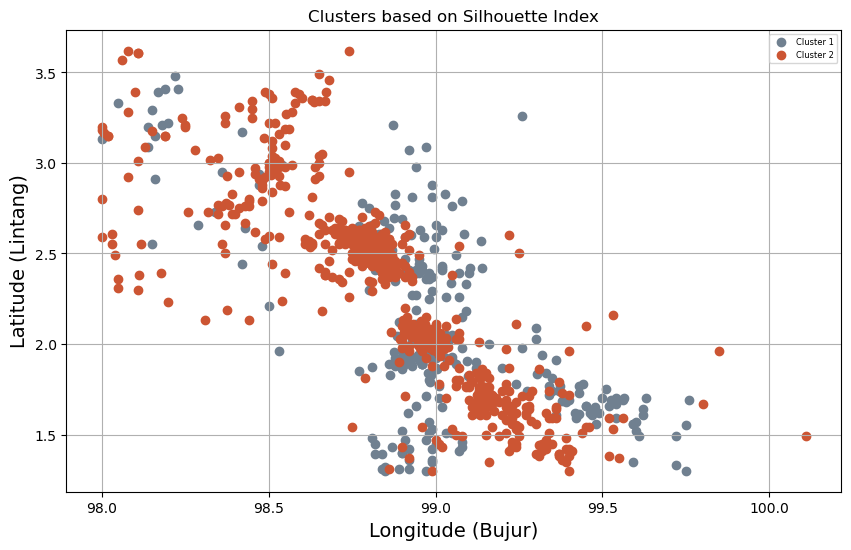

In [73]:
# Visualize the clusters in 2D space based on Silhouette
plt.figure(figsize=(10, 6))
for cluster, points in enumerate(optimal_cluster_points):
    cluster_color = optimal_cluster_colors[cluster]

    # Plot points within the cluster
    cluster_points_lat = [point[0] for point in points]
    cluster_points_lon = [point[1] for point in points]
    plt.scatter(cluster_points_lon, cluster_points_lat, c=cluster_color, label=f'Cluster {cluster+1}')

    # Plot cluster center and draw lines
    if optimal_medoids is not None:
        cluster_center = optimal_medoids[cluster]
        plt.scatter(cluster_center[1], cluster_center[0], c="red", marker="x", s=100, 
                    label=f'Silhouette Cluster {cluster+1} Center')
        for point in points:
            plt.plot([cluster_center[1], point[1]], [cluster_center[0], point[0]], c=cluster_color, linewidth=0.5)

plt.xlabel("Longitude (Bujur)", fontsize=14)
plt.ylabel("Latitude (Lintang)", fontsize=14)
plt.title("Clusters based on Silhouette Index")
plt.legend(prop={'size': 6})
plt.grid(True)
plt.show()


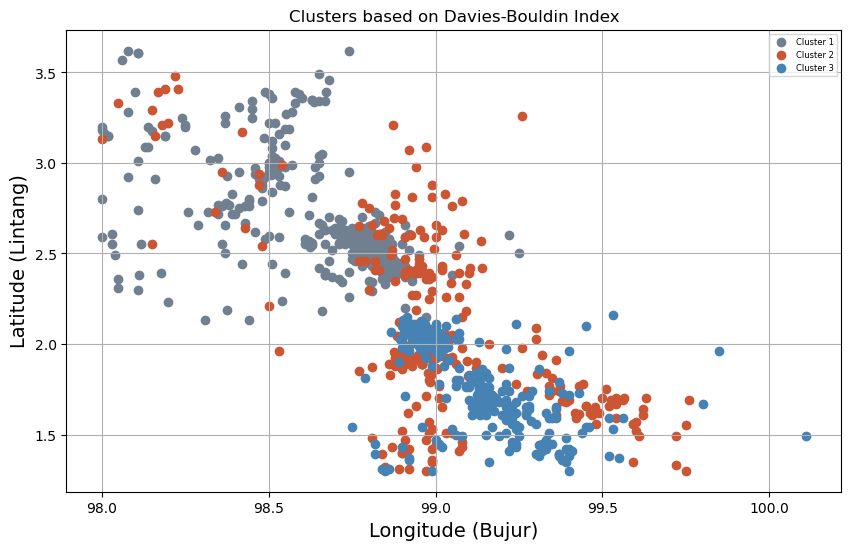

In [47]:
# Visualize the clusters in 2D space based on Davies-Bouldin Index
plt.figure(figsize=(10, 6))
for cluster, points in enumerate(optimal_cluster_points_davies_bouldin):  # Use points for Davies-Bouldin
    cluster_color = optimal_cluster_colors_davies_bouldin[cluster]  # Use colors for Davies-Bouldin

    # Plot points within the cluster
    cluster_points_lat = [point[0] for point in points]
    cluster_points_lon = [point[1] for point in points]
    plt.scatter(cluster_points_lon, cluster_points_lat, c=cluster_color, label=f'Cluster {cluster+1}')

    # Plot cluster center and draw lines
    if optimal_medoids_davies_bouldin is not None:  # Use medoids for Davies-Bouldin
        cluster_center = optimal_medoids_davies_bouldin[cluster]  # Use medoids for Davies-Bouldin
        plt.scatter(cluster_center[1], cluster_center[0], c="red", marker="x", s=100, label=f'Cluster {cluster+1} Center')
        for point in points:
            plt.plot([cluster_center[1], point[1]], [cluster_center[0], point[0]], c=cluster_color, linewidth=0.5)

plt.xlabel("Longitude (Bujur)", fontsize=14)
plt.ylabel("Latitude (Lintang)", fontsize=14)
plt.title("Clusters based on Davies-Bouldin Index")
plt.legend(prop={'size': 6})
plt.grid(True)
plt.show()

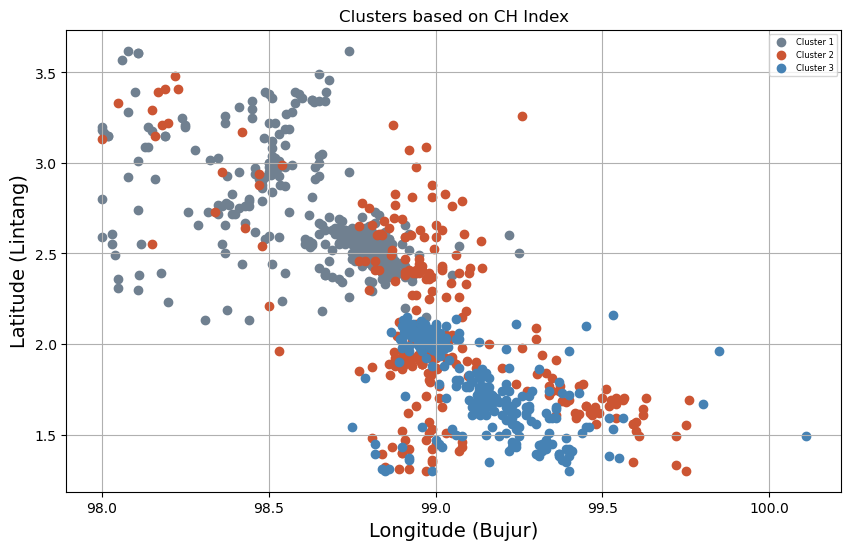

In [48]:
# Visualize the clusters in 2D space based on CH Index
plt.figure(figsize=(10, 6))
for cluster, points in enumerate(optimal_cluster_points_ch):  # Use points for CH Index
    cluster_color = optimal_cluster_colors_ch[cluster]  # Use colors for CH Index

    # Plot points within the cluster
    cluster_points_lat = [point[0] for point in points]
    cluster_points_lon = [point[1] for point in points]
    plt.scatter(cluster_points_lon, cluster_points_lat, c=cluster_color, label=f'Cluster {cluster+1}')

    # Plot cluster center and draw lines
    if optimal_medoids_ch is not None:  # Use medoids for CH Index
        cluster_center = optimal_medoids_ch[cluster]  # Use medoids for CH Index
        plt.scatter(cluster_center[1], cluster_center[0], c="red", marker="x", s=100, label=f'Cluster {cluster+1} Center')
        for point in points:
            plt.plot([cluster_center[1], point[1]], [cluster_center[0], point[0]], c=cluster_color, linewidth=0.5)

plt.xlabel("Longitude (Bujur)", fontsize=14)
plt.ylabel("Latitude (Lintang)", fontsize=14)
plt.title("Clusters based on CH Index")
plt.legend(prop={'size': 6})
plt.grid(True)
plt.show()

In [100]:
# Silhouette-Based Optimal K
optimal_cluster_labels = optimal_kmedoids.labels_

cluster_summary_silhouette = pd.DataFrame()
cluster_summary_silhouette['Cluster'] = optimal_cluster_labels
cluster_summary_silhouette['Depth'] = data['depth']
cluster_summary_silhouette['Magnitude'] = data['magnitude']
cluster_summary_silhouette['Latitude'] = data['latitude']
cluster_summary_silhouette['Longitude'] = data['longitude']

# Group by cluster and calculate cluster statistics
cluster_stats_silhouette = cluster_summary_silhouette.groupby('Cluster').agg(
    No_Cluster=pd.NamedAgg(column='Depth', aggfunc='count'),
    Avg_Depth=pd.NamedAgg(column='Depth', aggfunc='mean'),
    Avg_Magnitude=pd.NamedAgg(column='Magnitude', aggfunc='mean'),
    Avg_Latitude=pd.NamedAgg(column='Latitude', aggfunc='mean'),
    Avg_Longitude=pd.NamedAgg(column='Longitude', aggfunc='mean')
)

print(cluster_stats_silhouette)

         No_Cluster   Avg_Depth  Avg_Magnitude  Avg_Latitude  Avg_Longitude
Cluster                                                                    
0               283  124.455830       3.156133      2.093806      98.999339
1               786    7.870229       2.587145      2.302978      98.859595


In [101]:
# Davies-Bouldin Index-Based Optimal K
optimal_cluster_labels_davies_bouldin = optimal_kmedoids_davies_bouldin.labels_

cluster_summary_davies_bouldin = pd.DataFrame()
cluster_summary_davies_bouldin['Cluster'] = optimal_cluster_labels_davies_bouldin
cluster_summary_davies_bouldin['Depth'] = data['depth']
cluster_summary_davies_bouldin['Magnitude'] = data['magnitude']
cluster_summary_davies_bouldin['Latitude'] = data['latitude']
cluster_summary_davies_bouldin['Longitude'] = data['longitude']

# Group by cluster and calculate cluster statistics
cluster_stats_davies_bouldin = cluster_summary_davies_bouldin.groupby('Cluster').agg(
    No_Cluster=pd.NamedAgg(column='Depth', aggfunc='count'),
    Avg_Depth=pd.NamedAgg(column='Depth', aggfunc='mean'),
    Avg_Magnitude=pd.NamedAgg(column='Magnitude', aggfunc='mean'),
    Avg_Latitude=pd.NamedAgg(column='Latitude', aggfunc='mean'),
    Avg_Longitude=pd.NamedAgg(column='Longitude', aggfunc='mean')
)

print(cluster_stats_davies_bouldin)

         No_Cluster   Avg_Depth  Avg_Magnitude  Avg_Latitude  Avg_Longitude
Cluster                                                                    
0               469    8.377399       2.364293      2.660232      98.673199
1               271  126.516605       3.158618      2.096262      99.014254
2               329    9.702128       2.923533      1.784049      99.118118


In [102]:
# CH Index-Based Optimal K
optimal_cluster_labels_ch = optimal_kmedoids_ch.labels_

cluster_summary_ch = pd.DataFrame()
cluster_summary_ch['Cluster'] = optimal_cluster_labels_ch
cluster_summary_ch['Depth'] = data['depth']
cluster_summary_ch['Magnitude'] = data['magnitude']
cluster_summary_ch['Latitude'] = data['latitude']
cluster_summary_ch['Longitude'] = data['longitude']

# Group by cluster and calculate cluster statistics
cluster_stats_ch = cluster_summary_ch.groupby('Cluster').agg(
    No_Cluster=pd.NamedAgg(column='Depth', aggfunc='count'),
    Avg_Depth=pd.NamedAgg(column='Depth', aggfunc='mean'),
    Avg_Magnitude=pd.NamedAgg(column='Magnitude', aggfunc='mean'),
    Avg_Latitude=pd.NamedAgg(column='Latitude', aggfunc='mean'),
    Avg_Longitude=pd.NamedAgg(column='Longitude', aggfunc='mean')
)

print(cluster_stats_ch)

         No_Cluster   Avg_Depth  Avg_Magnitude  Avg_Latitude  Avg_Longitude
Cluster                                                                    
0               469    8.377399       2.364293      2.660232      98.673199
1               271  126.516605       3.158618      2.096262      99.014254
2               329    9.702128       2.923533      1.784049      99.118118
